<a href="https://colab.research.google.com/github/AllanKamimura/Pai_ta_ON_python/blob/main/school/SME0320_Statistics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Inicializando as coisas

In [50]:
print("instalando pacotes....")
!pip install -qq plotly==4.5.2
!pip install -qq tensorflow_addons
!pip install -qq tensorflow_decision_forests
!pip install -qq wurlitzer

import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
sns.set_theme("poster")

import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_decision_forests as tfdf
print("Found TensorFlow Decision Forests v" + tfdf.__version__)

from wurlitzer import sys_pipes
from google_drive_downloader import GoogleDriveDownloader

#@title #Inicializar as coisa
#@markdown Baixar arquivo do Google Drive
file_id = "1vayCD1wyi4lA9BbR8lR9xoAaZkjs402t" #@param {type:"string"}
#@markdown nome do arquivo:
file_name  = "Glassdoor Gender Pay Gap.csv" #@param {type:"string"}
# faz o download do dataset
GoogleDriveDownloader.download_file_from_google_drive(
    file_id = file_id,
    dest_path = "./{}".format(file_name),
    overwrite = True
)

df = pd.read_csv("/content/{}".format(file_name),
                 dtype = {"JobTitle" : "category", # algumas colunas são categoricas
                          "Gender" : "category",
                          "Dept" : "category",
                          "PerfEval": "category",
                          "Education": "category",
                          "Seniority": "category"})

print()
df.head()

instalando pacotes....
Found TensorFlow Decision Forests v0.2.2



,JobTitle,Gender,Age,PerfEval,Education,Dept,Seniority,BasePay,Bonus
0,Graphic Designer,Female,18,5,College,Operations,2,42363,9938
1,Software Engineer,Male,21,5,College,Management,5,108476,11128
2,Warehouse Associate,Female,19,4,PhD,Administration,5,90208,9268
3,Software Engineer,Male,20,5,Masters,Sales,4,108080,10154
4,Graphic Designer,Male,26,5,Masters,Engineering,5,99464,9319


In [51]:
#@title #Create New Columns
# colunas com relação de ordem
df.PerfEval.cat.as_ordered(inplace = True)
df.Education.cat.set_categories(["High School", "College", "Masters", "PhD"], 
                                ordered = True, inplace = True)

# colunas auxiliares
df["TotalPay"] = df["BasePay"] + df["Bonus"]

df["Male"] = df.Gender.apply(lambda row: True if row == "Male" else False)
df["Female"] = df.Gender.apply(lambda row: True if row == "Female" else False)
df["Male"] = df["Male"].astype(dtype = "bool")
df["Female"] = df["Female"].astype(dtype = "bool")

df["PerfEval_numeric"] = df["PerfEval"].astype(dtype = "int64")
age_cat = pd.cut(df.Age, 
                 bins = [0,20,30,40,50,60,100],
                 labels =[" 0-19","20-29","30-39","40-49","50-59","60+  "])
df.insert(loc = 3, column = "AgeCat", value = age_cat)

pay_cat = pd.cut(df["TotalPay"], 6, labels = ["( 40684.818,  64691.667]" , 
                                              "( 64691.667,  88555.333]" ,
                                              "( 88555.333, 112419.000]" , 
                                              "(112419.000, 136282.667]" ,
                                              "(136282.667, 160146.333]" , 
                                              "(160146.333, 184010.000]"])
df.insert(loc = 11, column = "PayClass", value = pay_cat)

print()
df.head()

,JobTitle,Gender,Age,AgeCat,PerfEval,Education,Dept,Seniority,BasePay,Bonus,TotalPay,PayClass,Male,Female,PerfEval_numeric
0,Graphic Designer,Female,18,0-19,5,College,Operations,2,42363,9938,52301,"( 40684.818, 64691.667]",False,True,5
1,Software Engineer,Male,21,20-29,5,College,Management,5,108476,11128,119604,"(112419.000, 136282.667]",True,False,5
2,Warehouse Associate,Female,19,0-19,4,PhD,Administration,5,90208,9268,99476,"( 88555.333, 112419.000]",False,True,4
3,Software Engineer,Male,20,0-19,5,Masters,Sales,4,108080,10154,118234,"(112419.000, 136282.667]",True,False,5
4,Graphic Designer,Male,26,20-29,5,Masters,Engineering,5,99464,9319,108783,"( 88555.333, 112419.000]",True,False,5


# Explorando o Dataset
O Objetivo da nossa analise é determinar os fatores que influenciam o valor do salario de uma pessoa, 
com interesse principalmente na variavel Genero

## Caracteristicas Gerais

In [ ]:
df.Gender.value_counts()

Male      532
Female    468
Name: Gender, dtype: int64

,BasePay,Age
BasePay,1.000000,0.562681
Age,0.562681,1.000000


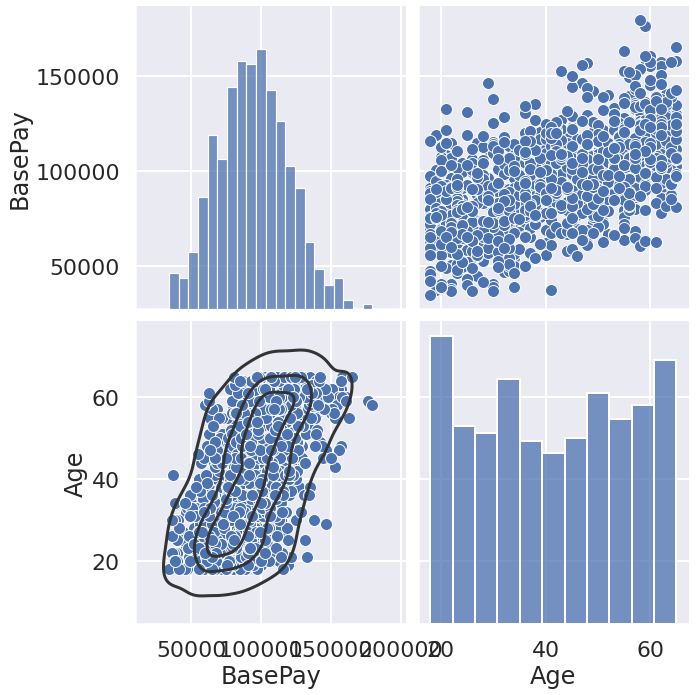

In [56]:
_ = sns.pairplot(data = df[["BasePay", "Age"]], height = 5)
_.map_lower(sns.kdeplot, levels = 4, color = ".2")

df[["BasePay", "Age"]].corr()

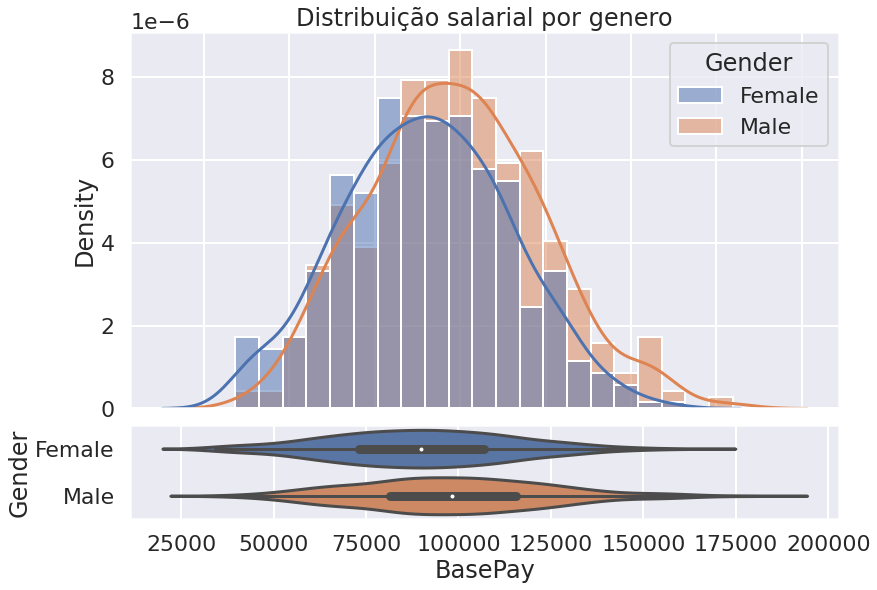

In [ ]:
fig, ax = plt.subplots(2,1, figsize = (12,8), gridspec_kw={'height_ratios': [4, 1]})
_ = sns.kdeplot(data = df, x = "BasePay", hue = "Gender", ax = ax[0])
_ = sns.histplot(data = df, x = "BasePay", hue = "Gender", stat = "density", ax = ax[0])
ax[0].set_xlabel("")
ax[0].set_xticklabels("")
ax[0].set_title("Distribuição salarial por genero")
_ = sns.violinplot(data = df, x = "BasePay", y = "Gender", ax = ax[1], legend = False)
fig.tight_layout(pad=0)

# parece q é bem obvio que existe essa dispariedade de salarios entre homens e mulheres
# aqui, os homens são maioria do lado direito da distribuição
# enquanto as mulheres são maioria do lado esquerdo

In [ ]:
from IPython import display
display.Latex("$\mu_{female} = 89942,  \sigma_{female} = 24378$")
display.Latex("$\mu_{male} = 98457,  \sigma_{male} = 25517$")

<IPython.core.display.Latex object>

Operations        210
Sales             207
Management        198
Administration    193
Engineering       192
Name: Dept, dtype: int64


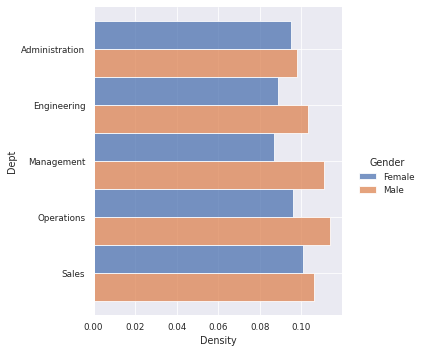

In [ ]:
print(df.Dept.value_counts())
_ = sns.displot(data = df, y = "Dept", hue = "Gender", multiple = "dodge", stat = "density")

# Acho q so o Managements tem um numero expressivo a mais de homens

In [ ]:
df.JobTitle.value_counts()

# 10 cargos diferentes com uma boa distribuição

Marketing Associate    118
Software Engineer      109
Financial Analyst      107
Data Scientist         107
Graphic Designer        98
IT                      96
Sales Associate         94
Driver                  91
Warehouse Associate     90
Manager                 90
Name: JobTitle, dtype: int64

## JobTitle

(0.0, 1.0, 0.0, 1.0)

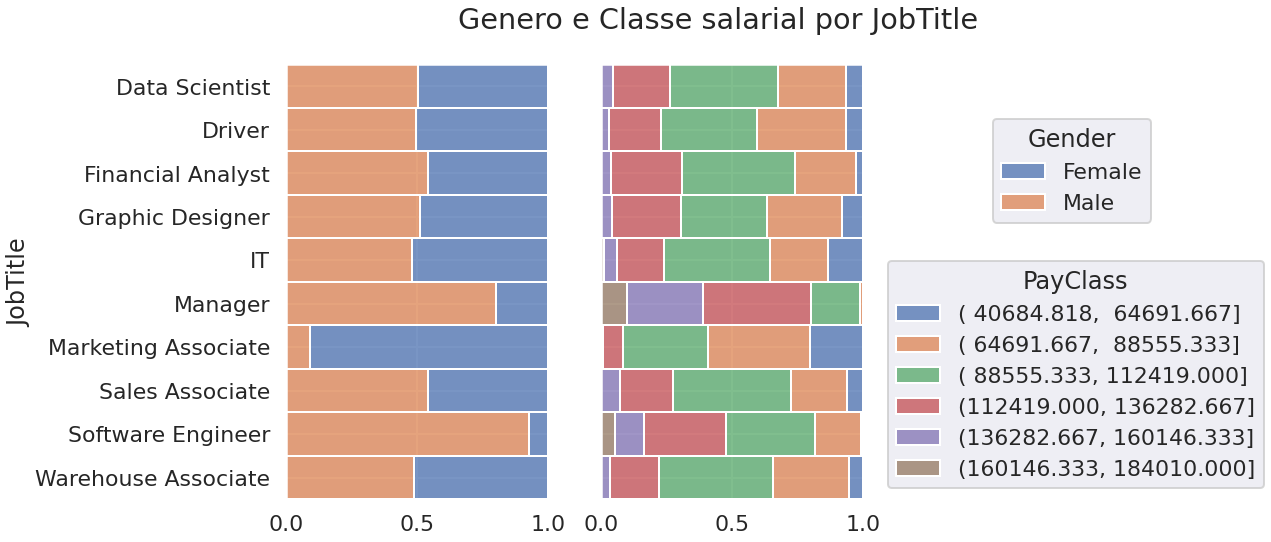

In [52]:
fig, ax = plt.subplots(1,3, figsize = (16,8))
fig.suptitle("Genero e Classe salarial por JobTitle")

l = sns.histplot(data = df, y = "JobTitle", hue = "Gender", multiple = "fill", ax = ax[0], legend = True)
r = sns.histplot(data = df, y = "JobTitle", hue = "PayClass", multiple = "fill", ax = ax[1], legend = True)
sns.move_legend(ax[0], 2, bbox_to_anchor=(2.65, 0.9))
sns.move_legend(ax[1], 3, bbox_to_anchor=(1.05, 0))

ax[1].set_ylabel("")
ax[1].set_xlabel("")
ax[0].set_xlabel("")
# ax[1].set_xticklabels("")
# ax[0].set_xticklabels("")
ax[1].set_yticklabels("")
ax[2].grid("off")
ax[2].axis("off")

# nas funções de Manager e Software Engineer quase não existem pessoas ganhando
# bem abaixo da media enquanto quase todos que ganham bem acima da média estão
# nessas linhas de trabalho
# por outro lado, a função de Marketing Associate, praticamente não tem pessoas
# na faixa ganham bem e bem acima da media, enquanto concentra a maior parcela
# de pessoas ganhando bem abaixo da media
# aqui ja percebemos que nesse dataset há um certo desbalanço com relação a distribuiçao
# de cargos em função do genero

# Existem muito mais homens com o cargo de "Software Engineer" e "Manager"
# Existem muito mais mulheres com o cargo "Marketing Associate" doq homens
# esse é um bom inicio para se analisar: o salario medio dessas profissoes

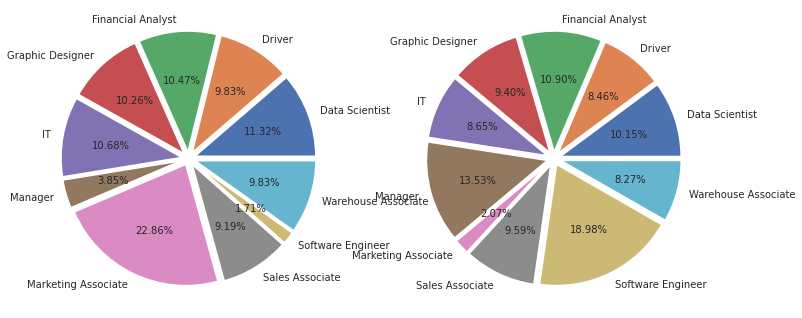

In [75]:
_ = df.groupby(
    "Gender"
    ).agg(
        {"JobTitle": "value_counts"}
        ).unstack(
            level = "Gender"
            ).plot.pie(
                subplots = True, autopct = "%.2f%%", legend = False, figsize = (12,8),
                xlabel = "", ylabel = "", fontsize = 10, explode = [0.05] * 10,)

# mesma coisa de cima, mas grafico de pizza e valores numericos
# esqueda = Female, direita = Male
# de fato essas 3 profissões são as mais desbalanceadas

In [ ]:
# Funções auxiliares
def q25(row):
    return np.quantile(row, q = 0.25)
def q75(row):
    return np.quantile(row, q = 0.75)
def iqr(row):
    return np.quantile(row, q = 0.75) - np.quantile(row, q = 0.25)
def remove_out(row):
    Q1 = q25(row)
    Q3 = q75(row)
    IQR = iqr(row)
    return row[(row > (Q1 - 1.5 * IQR)) & (row < (Q3 + 1.5 * IQR))]

In [ ]:
df.groupby(["JobTitle"]).agg({"TotalPay" : [q25, np.mean, q75],
                              "Male": np.sum,
                              "Female": np.sum}).round(2)

# trabalhos com maior media de salarios: Manager e Software Engineer
# trabalhos com menor media de salarios: Marketing Associate
# curiosamente os mesmos de cima
# cqd 

# uma observação é que no dataset temos apenas 
# 8 mulheres Software Engineer
# 11 homens Marketing Associate
# oq pode tornar as analises não tão representativas de grupo, mas analises individuais

TotalPay                       Male Female
                           q25       mean        q75  sum    sum
JobTitle                                                        
Data Scientist        82360.50   98918.41  112774.00   54     53
Driver                80440.00   95778.89  111381.00   45     46
Financial Analyst     87219.00  101403.63  119457.50   58     49
Graphic Designer      80813.25   97674.53  113582.50   50     48
IT                    81252.25   97030.40  112214.25   46     50
Manager              117143.75  131392.18  148183.00   72     18
Marketing Associate   66317.25   82802.13   98530.50   11    107
Sales Associate       86983.00   99670.79  115922.25   51     43
Software Engineer     94622.00  112161.41  128166.00  101      8
Warehouse Associate   84424.75   96798.44  111798.25   44     46

In [ ]:
df.groupby(["JobTitle", "Gender"]).agg({"TotalPay" : [q25, np.mean, q75]}).unstack().round(2)

# na media:
# mulheres ganham mais: "Data Scientist", "Graphic Designer", "Warehouse Associate"
# homens ganham mais: "Driver", "Marketing Associate", "Sales Associate", "Software Engineer"
# equilibrados: "Financial Analyst", "IT", "Manager"

TotalPay             ...                      
                           q25             ...        q75           
Gender                  Female       Male  ...     Female       Male
JobTitle                                   ...                      
Data Scientist        84837.00   79525.25  ...  119460.00  110800.75
Driver                80351.25   80768.00  ...  108367.75  114432.00
Financial Analyst     85511.00   88153.25  ...  122402.00  114926.75
Graphic Designer      81192.00   78923.50  ...  116085.25  112472.75
IT                    80742.25   84163.50  ...  114366.00  108463.00
Manager              115318.00  117279.25  ...  150110.50  143228.50
Marketing Associate   66018.50   69488.50  ...   98990.00   97749.50
Sales Associate       87005.00   86958.50  ...  109609.50  117785.00
Software Engineer     91676.00   94976.00  ...  113973.25  130317.00
Warehouse Associate   89351.25   77791.75  ...  111904.75  110123.75

[10 rows x 6 columns]

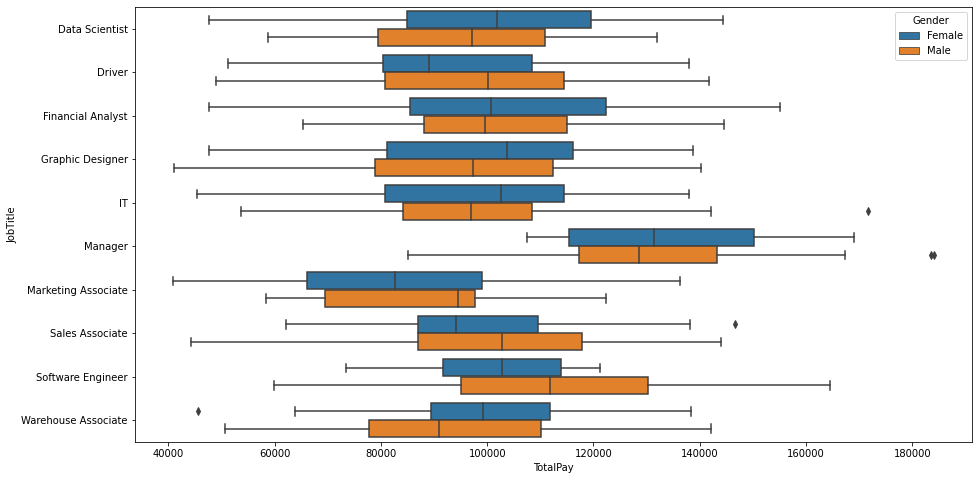

In [ ]:
fig, axes = plt.subplots(figsize = (15, 8))

_ = sns.boxplot(data = df, x = "TotalPay", y = "JobTitle", hue = "Gender")

# Vale ressaltar as profissoes de "Software Engineer", "Makerting Associate" e "Driver"
# em que temos o Q2 dos homens proximo ao Q3 das mulheres
# alem disso, a diferença entre os Q3s de "Software Engineer" chega a quase 16000 dinheros

# Por outro lado, para a profissao de "Warehouse Associate"
# temos o Q1 das mulheres proximo ao Q2 dos homens

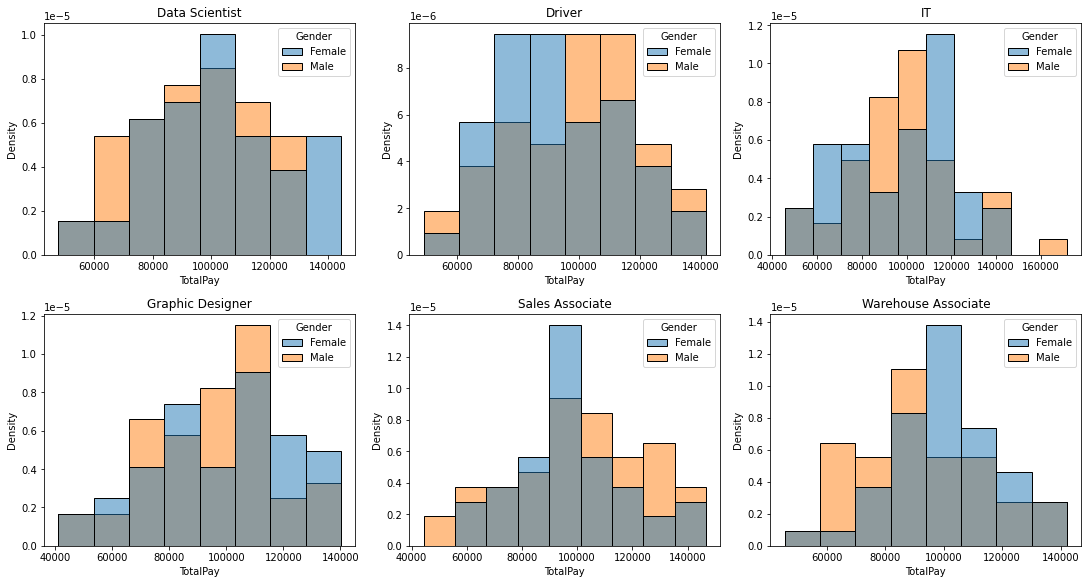

In [ ]:
# agora, vamos analisar separadamente os salarios nos empregos em que 
# a proporção entre a quantidade de homens e mulheres é proxima
# (pra gerar uma analise menos tendenciosa) 
# "Data Scientist", "Driver", "IT", "Graphic Designer", "Sales Associate", "Warehouse Associate"

empregos_prox = ["Data Scientist", "Driver", "IT", "Graphic Designer", "Sales Associate", "Warehouse Associate"]
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (15,8), constrained_layout = True)

for n, emprego in enumerate(empregos_prox):
    if n in [0,1,2]:
        lugar = axes[0,n]
    if n in [3,4,5]:
        lugar = axes[1,n-3]

    lugar.title.set_text(emprego)
    _ = sns.histplot(data = df[(df["JobTitle"] == emprego)], 
                x = "TotalPay", hue = "Gender", stat = "density", 
                ax = lugar)
    
# empregos com mais mulheres ganhando mais: "Warehouse Associate"
# empregos com mais homens ganhando mais: "Driver", "Sales Associate"
# os outros parecem mais distribuidos

# oq tiramos daqui é q existem 2 formas que fazem as mulheres ganharem menos
# ter empregos que pagam menos
# ganhar menos no mesmo emprego

## Age

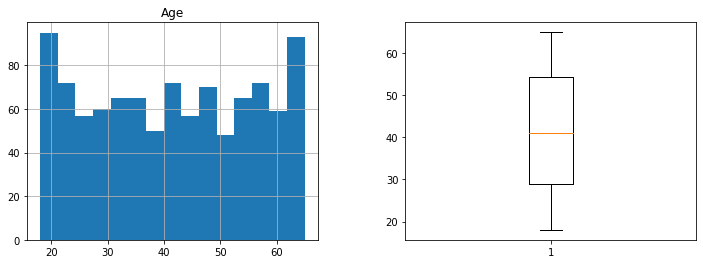

In [ ]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (12,4))
_ = df.hist("Age", bins = 15, ax = axes[0])
_ = plt.boxplot(df["Age"])

# tem uma boa distribuição de idades, uniforme no centro
# com um pouco mais de pessoas nos extremos, mas sem outliers

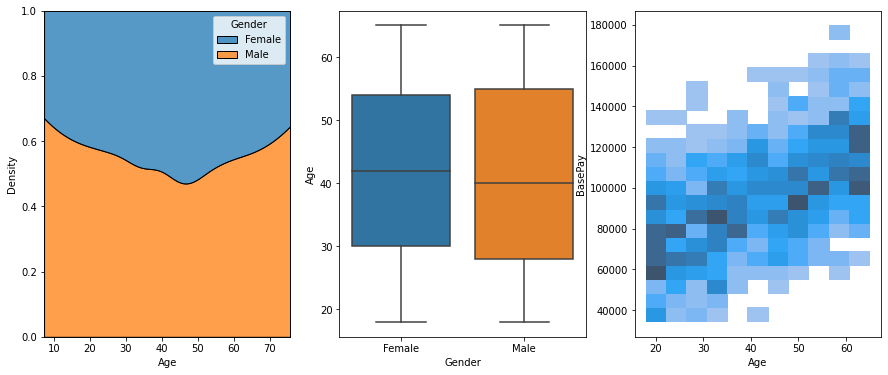

In [ ]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (15, 6))
_ = sns.kdeplot(data = df, x = "Age", hue = "Gender", multiple = "fill", ax = axes[0])
_ = sns.boxplot(data = df, x = "Gender", y = "Age", ax = axes[1])
_ = sns.histplot(data = df, x = "Age", y = "BasePay")

In [ ]:
df.groupby(["JobTitle", "Gender"]).agg({"Age" : [q25, np.mean, q75]}).unstack("Gender").round(0)

# observamos que as profissões com mulheres mais velhas doq homens são:
# "Marketing Associate" e "Data Scientist"
# enquanto "Software Engineer" tem homens mais velhos

Age                                
                       q25         mean          q75      
Gender              Female  Male Female  Male Female  Male
JobTitle                                                  
Data Scientist        33.0  28.0   43.0  40.0   55.0  54.0
Driver                29.0  32.0   42.0  42.0   55.0  54.0
Financial Analyst     30.0  29.0   41.0  41.0   49.0  51.0
Graphic Designer      30.0  24.0   41.0  40.0   51.0  54.0
IT                    32.0  29.0   43.0  41.0   54.0  55.0
Manager               32.0  30.0   45.0  42.0   56.0  56.0
Marketing Associate   30.0  26.0   42.0  37.0   55.0  47.0
Sales Associate       31.0  27.0   42.0  43.0   55.0  58.0
Software Engineer     28.0  27.0   37.0  41.0   45.0  58.0
Warehouse Associate   26.0  26.0   40.0  39.0   51.0  49.0

In [ ]:
df.groupby(["AgeCat"]).agg({"Male" : np.sum, "Female": np.sum})

,Male,Female
AgeCat,,
Trainee,45,30
Junior,119,90
Medio,107,93
Experiente,87,108
Senior,114,96
semi-Aposentado,60,51


In [ ]:
df.groupby(["AgeCat","Dept"]).agg({"Male" : np.sum, "Female": np.sum}).unstack("AgeCat")

# tanto as colunas "Senior" quanto "semi-Aposentado" possuem um numero maior de homens
# quando comparadas com as mulheres do mesmo setor

Male               ...     Female                       
AgeCat         Trainee Junior Medio  ... Experiente Senior semi-Aposentado
Dept                                 ...                                  
Administration       7     22    21  ...         23     15              12
Engineering          9     31    21  ...         21     19               9
Management           7     24    25  ...         20     19               7
Operations          13     19    22  ...         21     21               9
Sales                9     23    18  ...         23     22              14

[5 rows x 12 columns]

Text(0.5, 1.0, 'Boxplot salario por faixa etaria')

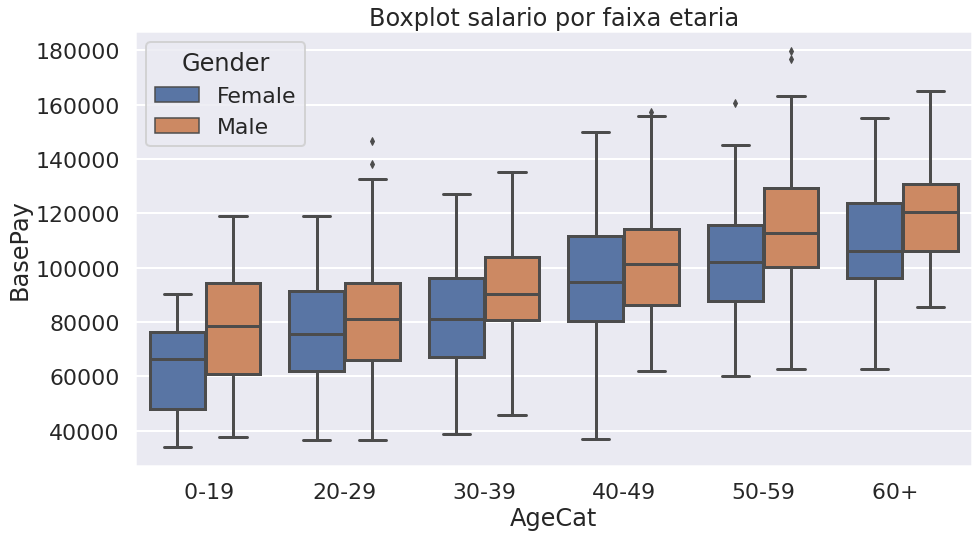

In [58]:
fig, axes = plt.subplots(figsize = (15, 8))

_ = sns.boxplot(data = df, x = "AgeCat", y = "BasePay", hue = "Gender")
plt.title("Boxplot salario por faixa etaria")
# df.groupby(["AgeCat", "Gender"]).agg({"TotalPay": [q25, np.mean, q75]}).unstack("Gender").round(2)

# Aqui podemos ver que, de fato, há uma relação crescente entre idade e salario total
# Então, um numero menor de mulheres mais velhas contribui para a diferença salarial

# Alem disso, percebemos que para todas as faixas etarias, todos os quartiles
# do boxplot dos homens estão a cima dos das mulheres

In [77]:
sun_df = df.groupby(['AgeCat','Education','Gender'],
                    as_index = False).agg({"TotalPay": "mean"})

px.sunburst(sun_df, path = ["AgeCat", "Education", "Gender"],
            color = "TotalPay", color_continuous_scale = "bugn",
            title = "Diferença salarial entre pessoas da mesma faixa etaria e com a mesma formação academica",
            labels = {"TotalPay":"Average Total Pay"})

# eu fiz um outro grafico parecido, mas usando as categorias de idade
# dai fica bem evidente a tendencia de maiores salarios para pessoas mais velhas
# mas tambm evidencia bastante a relação salarial entre homens e mulheres
# aqui, praticamente em todas as comparações, para pessoas da mesma faixa etaria
# e com a mesma formação, as mulheres ganham menos doq os homens

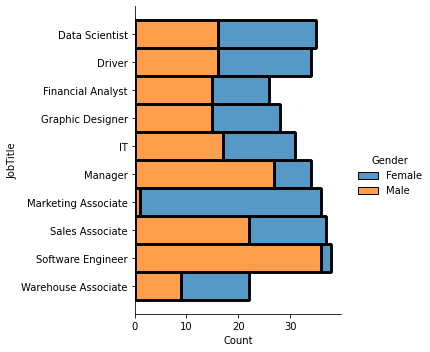

In [ ]:
_ = sns.displot(data = df[(df["Age"] > 50)], y = "JobTitle", stat = "count",
                hue = "Gender", multiple = "stack")

# Grupo de pessoas com mais de 50 anos
# aparentemente, não tem um cargo predominante para pessoas com mais de 50 anos

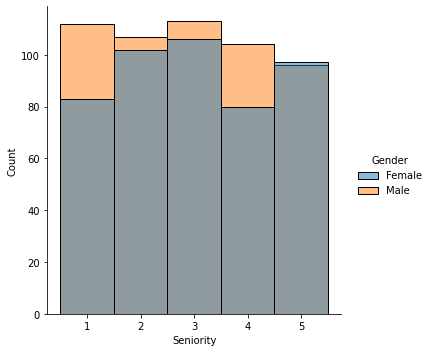

In [ ]:
_ = sns.displot(df, x = "Seniority", hue = "Gender", multiple = "layer")

# Existe uma maior quantidade de homens com 1 e 4 anos de empresa
# mais homens em inicio de carreira sendo contratados? 
# na real, não sei como interpretar essa variavel
# pq pra mim não faz sentido so ter numeros de 1 a 5
# acho q vou dropar essa coluna

## PerfEval

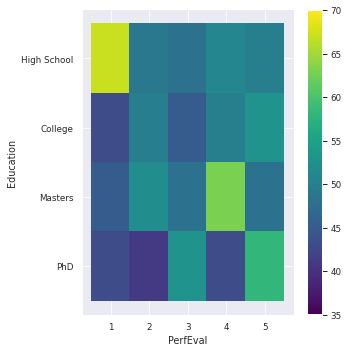

In [49]:
_ = sns.displot(data = df, x = "PerfEval", 
                  y = "Education", cbar = True, cmap = "viridis", vmin = 35, vmax = 70)


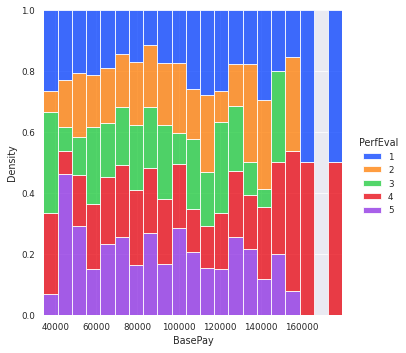

In [ ]:
_ = sns.displot(df, x = "BasePay", hue = "PerfEval", multiple = "fill", stat = "density")

# percebemos uma relação crescente entre uma maior avaliação de performace
# e a frequencia normalizada de homens com essa avaliação
# ou seja, podemos supor que as pessoas mais bem avaliadas tem  
# uma tendencia maior de serem homens

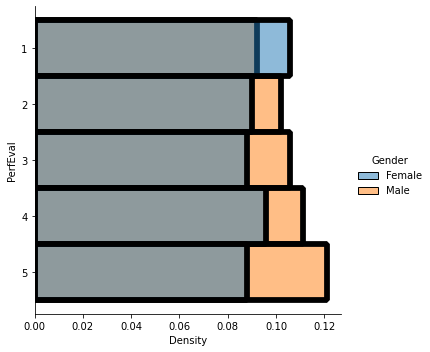

In [ ]:
_ = sns.displot(df, y = "PerfEval", hue = "Gender", multiple = "layer", stat = "density")

# percebemos uma relação crescente entre uma maior avaliação de performace
# e a frequencia normalizada de homens com essa avaliação
# ou seja, podemos supor que as pessoas mais bem avaliadas tem  
# uma tendencia maior de serem homens

In [ ]:
df.groupby(["JobTitle", "Gender"]).agg({"PerfEval_numeric" : [q25, np.mean, q75]}).unstack()

# Homens são melhor avaliados: "Driver", "Financial Analyst", "Graphic Designer", 
#                               "Manager", "Software Engineer"

# doq vimos em JobTitles, 
# homens ganham mais: "Driver", "Marketing Associate", "Sales Associate", "Software Engineer"

# "Driver" e "Software Engineer" estão na intersecção
# mas isso não é o suficiente para podermos estabelecer 
# uma relação causal entre as as avaliações e o salario


PerfEval_numeric                                      
                                 q25            mean              q75     
Gender                        Female  Male    Female      Male Female Male
JobTitle                                                                  
Data Scientist                  2.00  1.25  3.037736  2.907407   4.00  4.0
Driver                          2.00  2.00  2.913043  3.222222   4.00  4.0
Financial Analyst               2.00  2.25  3.000000  3.500000   4.00  5.0
Graphic Designer                1.00  2.00  2.791667  3.440000   4.00  5.0
IT                              2.00  2.00  3.080000  3.173913   4.75  4.0
Manager                         1.00  2.00  2.388889  2.777778   3.75  4.0
Marketing Associate             2.00  2.00  2.897196  3.181818   4.00  4.0
Sales Associate                 2.00  2.00  2.674419  2.901961   3.50  4.0
Software Engineer               1.75  2.00  2.750000  3.158416   4.00  5.0
Warehouse Associate             2.00  2.00  3.347826  3.136364   4.75  5.0

PerfEval                                               
AgeCat           Trainee Junior Medio Experiente Senior semi-Aposentado
PerfEval Gender                                                        
1        Female        6     19    15         26     26              14
         Male          5     22    18         12     23              12
2        Female        8     12    14         19     27              10
         Male         10     19    25         20     19               9
3        Female        4     18    19         24     13              10
         Male          5     24    23         23     20              11
4        Female        6     26    20         19     16               9
         Male         14     27    18         14     27              11
5        Female        6     15    25         20     14               8
         Male         11     27    23         18     25              17

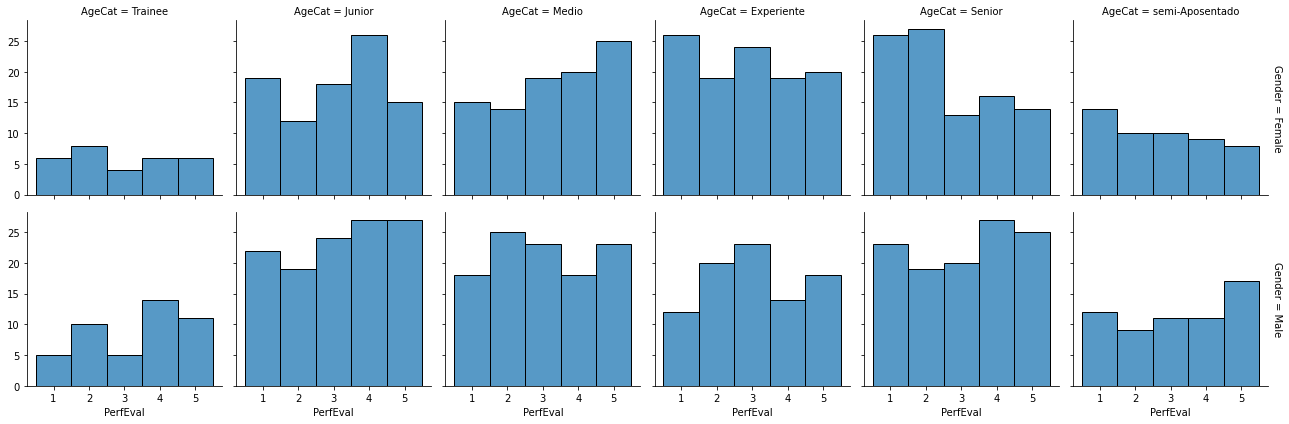

In [ ]:
grid = sns.FacetGrid(df, col = "AgeCat", row = "Gender", margin_titles = True)
_ = grid.map(sns.histplot, "PerfEval")

df.groupby(
    ["AgeCat", "PerfEval", "Gender"]
    ).agg({"PerfEval": "count"}).unstack(["AgeCat"])

# é meio dificil afirmar as coisas com poucas observações, mas

# para os trainees, 
# a evaluation das mulheres parece seguir uma distribuição uniforme
# enquanto para os homens, ela é ligeiramente deslocada para notas mais altas

# Para os seniors,
# a evaluation dos homens parece seguir uma distribuição uniforme
# enquanto para as mulheres, ela é bastante deslocada para notas mais baixas

# para os semi-aposentados,
# para as mulheres, há uma leve inclinação para notas mais baixas
# para os homens, há uma leve inclinação para notas mais altas

In [ ]:
#@title Correlação entre PerfEval e TotalPay {run:"auto"}
#@markdown selecione uma categoria
AgeCat = "semi-Aposentado" #@param ["Trainee", "Junior", "Medio", "Experiente", "Senior", "semi-Aposentado"]
df[df["AgeCat"] == AgeCat][["PerfEval_numeric", "TotalPay"]].corr()

#@markdown Entretanto, para todas as categorias, a correlação entre PerfEval e TotalPay é baixa

,PerfEval_numeric,TotalPay
PerfEval_numeric,1.000000,0.197549
TotalPay,0.197549,1.000000


In [ ]:
#@title Correlação entre PerfEval e TotalPay {run:"auto"}
#@markdown selecione uma categoria
Departamento = "Administration" #@param ["Operations", "Sales", "Management", "Administration", "Engineering"]
df[df["Dept"] == Departamento][["PerfEval_numeric", "TotalPay"]].corr()

#@markdown Entretanto, para todas as categorias, a correlação entre PerfEval e TotalPay é baixa

,PerfEval_numeric,TotalPay
PerfEval_numeric,1.000000,0.020202
TotalPay,0.020202,1.000000


In [ ]:
df[df["Male"] == True][["PerfEval_numeric", "TotalPay"]].corr()

,PerfEval_numeric,TotalPay
PerfEval_numeric,1.000000,0.023105
TotalPay,0.023105,1.000000


In [ ]:
df[df["Female"] == True][["PerfEval_numeric", "TotalPay"]].corr()

,PerfEval_numeric,TotalPay
PerfEval_numeric,1.000000,-0.020616
TotalPay,-0.020616,1.000000


## Education

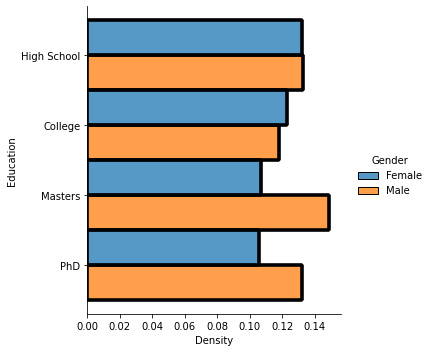

In [ ]:
_ = sns.displot(df, y = "Education", hue = "Gender", multiple = "dodge", stat = "density")

# Temos muito mais homens com nivel de "Masters" e "PhD" doq mulheres
# e uma distribuição mais ou menos equilibrada para "High School" e "College"

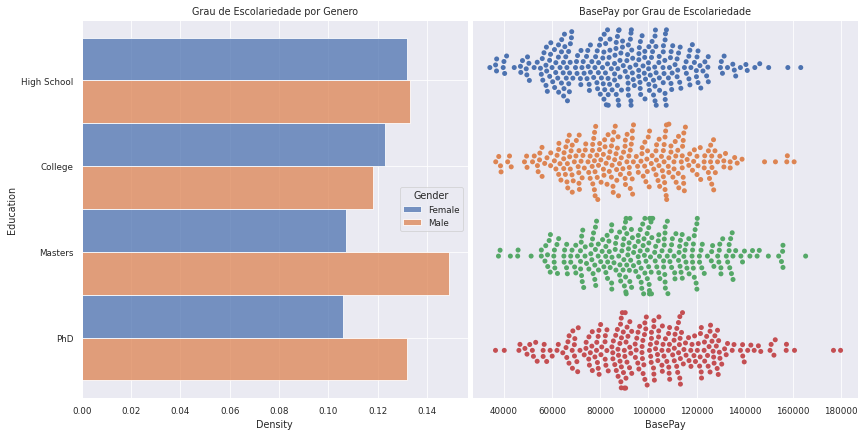

In [35]:
sns.set_theme("paper", style = "darkgrid",
              palette = "deep")
fig, ax = plt.subplots(1, 2, figsize = (12,6))
_ = sns.histplot(df, y = "Education", hue = "Gender", multiple = "dodge", stat = "density", ax = ax[0])
# _ = sns.histplot(df, x = "BasePay", hue = "Education", multiple = "stack", stat = "density", ax = ax[1])
_ = sns.swarmplot(data = df, x = "BasePay", y = "Education", ax = ax[1])

ax[0].set_title("Grau de Escolariedade por Genero")
ax[1].set_title("BasePay por Grau de Escolariedade")
ax[1].set_ylabel("")
ax[1].set_yticklabels("")
plt.tight_layout(pad = 0.5)
# Temos muito mais homens com nivel de "Masters" e "PhD" doq mulheres
# e uma distribuição mais ou menos equilibrada para "High School" e "College"

In [ ]:
df.groupby(by = ["JobTitle", "Education"]).agg({"BasePay": np.mean}).unstack()

# ampliando a distribuição de salarios por cargo, acrescentando a formação
# empregos com maior ganho salarial com pos-grad
# "Data Scientist", "Maketing Associate", "Sales Associate"

BasePay                                             
Education              High School        College        Masters            PhD
JobTitle                                                                       
Data Scientist        79332.862069   87545.600000  103075.827586   98262.482759
Driver                83746.238095   85609.333333   88040.238095  100673.318182
Financial Analyst     92615.259259   94758.730769   98248.285714   94206.730769
Graphic Designer      93589.350000   86913.769231   93068.656250   89886.300000
IT                    85373.727273   91192.785714   92910.916667   93150.681818
Manager              121673.250000  125497.347826  124892.666667  128346.692308
Marketing Associate   71226.026316   74794.777778   80948.461538   82027.555556
Sales Associate       86890.033333   88523.350000   97351.791667  103282.950000
Software Engineer    100214.906250  102522.526316  108695.843750  110309.846154
Warehouse Associate   86557.000000   89558.800000   86594.105263   96265.550000

In [ ]:
df.groupby(
    by = ["JobTitle", "Education"]
    ).agg(
        {"Male": np.sum,"Female": np.sum}
        ).groupby(
            level = "JobTitle"
            ).apply(
                lambda x: round((100 * x / x.sum()), 2)
                ).unstack()

# ta, oq eu queria observar fazendo essa escadinha gigante era se aquela diferença de salarios
# laaaa do começo, entre as profissões era devido a formação academica

# em "Marketing Associate", por exemplo, 
# a maior parcela de mulheres tem formação "High School"
# enquanto os homens tem formação "PhD"
# Embora em "Financial Analyst" tenhamos mais "Masters" e "PhD" homens
# e o Q3 das mulheres é consideravelmente maior doq o dos homens

# enquanto que, "Sales Associate" e "Software Engineer",
# dividindo em 2 grupos, (High School e College) / (Master e PhD)
# temos praticamente 50% de cada lado tanto para homens quanto para mulheres

Male                  ...  Female               
Education           High School College Masters  ... College Masters    PhD
JobTitle                                         ...                       
Data Scientist            29.63   16.67   29.63  ...   20.75   24.53  30.19
Driver                    22.22   33.33   20.00  ...   26.09   26.09  23.91
Financial Analyst         20.69   18.97   29.31  ...   30.61   22.45  16.33
Graphic Designer          20.00   14.00   46.00  ...   39.58   18.75  20.83
IT                        17.39   32.61   28.26  ...   26.00   22.00  24.00
Manager                   16.67   31.94   22.22  ...    0.00   27.78  27.78
Marketing Associate       18.18   27.27   18.18  ...   22.43   22.43  21.50
Sales Associate           37.25   13.73   27.45  ...   30.23   23.26  20.93
Software Engineer         29.70   16.83   30.69  ...   25.00   12.50  37.50
Warehouse Associate       31.82   25.00   18.18  ...   30.43   23.91  19.57

[10 rows x 8 columns]

In [54]:
sun_df = df.groupby(['Dept','Education','Gender'],
                    as_index = False).agg({"TotalPay": "mean"})

px.sunburst(sun_df, path = ["Dept", "Education", "Gender"],
            color = "TotalPay", color_continuous_scale = "bugn",
            title = "Salário por segmento, formação academica e genero",
            labels = {"TotalPay":"Average Total Pay"})

# mas realmente, todos os setores parecem favorecer as pessoas com master e PhD
# Alem disso, para pessoas com a mesma formação e trabalhando nos mesmos setores
# vemos q a tendencia é q os homens ganhem mais doq as mulheres
# dando destaque para alguns em q essa diferença é mais consideravel
# Engineering: PhD e Master
# Management: College e High School
# Operations: College e High School
# Sales: PhD, Master e College 
# Administration: PhD, Master e College 

# Estatistica

## Distribuição normal

In [116]:
df_copy = df[df["Male"]][["BasePay"]].copy()
mu = df[df["Male"]]["BasePay"].mean()

In [ ]:
df_copy["X-mu"] = df_copy["BasePay"] - mu
df_copy["(X-mu)²"] = df_copy["X-mu"] ** 2
df_copy.head(15)

In [129]:
df_copy["(X-mu)²"].sum() / (df_copy.shape[0] - 1)

651143843.6608613

In [147]:
# from IPython import display
import IPython
display.Latex("$\mu_{male} 	\\approx \overline{X} = 98457.54$")
display.Latex("$\sigma_{male}^2 \\approx s^2 = 651143843.66$")
display.Latex("$\sigma_{male} \\approx s = 25517.52$")

<IPython.core.display.Latex object>

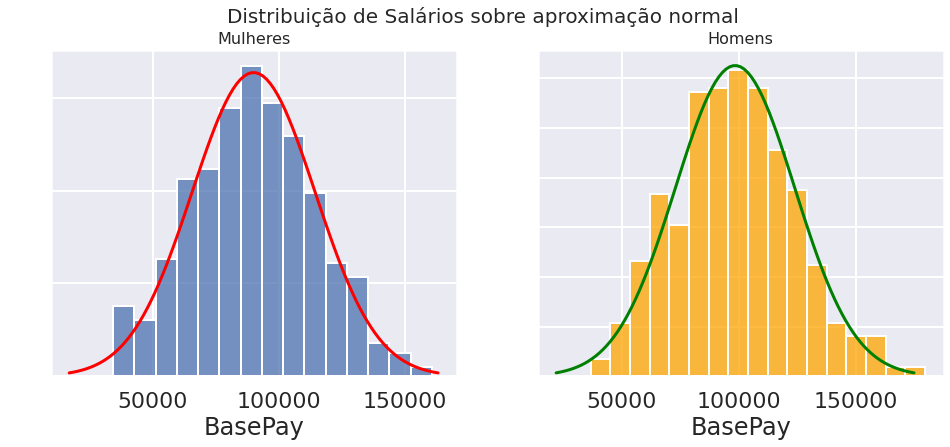

In [242]:
import scipy.stats
fig, ax = plt.subplots(1, 2, figsize = (16,6))
mu = df[df["Male"]]["BasePay"].mean()
sigma = df[df["Male"]]["BasePay"].std()
plt.suptitle("Distribuição de Salários sobre aproximação normal", fontsize = 20)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
ax[1].set_title("Homens", fontsize = 16)
ax[1].set_yticklabels([])
ax[1].set_ylabel(" ")

ax[1].plot(x, scipy.stats.norm.pdf(x, mu, sigma), color = "green")
sns.histplot(data = df[df["Male"]],
             x = "BasePay", stat = "density", ax = ax[1], color = "orange")

mu = df[df["Female"]]["BasePay"].mean()
sigma = df[df["Female"]]["BasePay"].std()

x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
ax[0].set_title("Mulheres", fontsize = 16)
ax[0].set_yticklabels([])
ax[0].set_ylabel(" ")


ax[0].plot(x, scipy.stats.norm.pdf(x, mu, sigma), color = "red")
sns.histplot(data = df[df["Female"]],
             x = "BasePay", stat = "density", ax = ax[0])
plt.show()

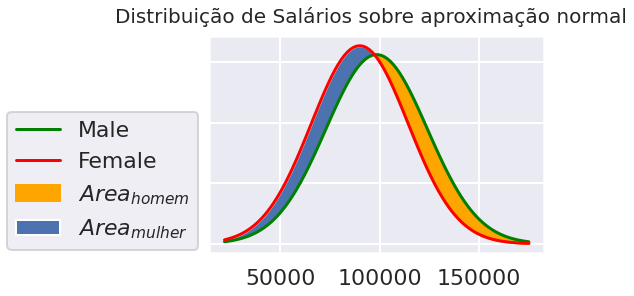

In [241]:
import scipy.stats
figure = plt.figure()
mu1 = df[df["Male"]]["BasePay"].mean()
sigma1 = df[df["Male"]]["BasePay"].std()
plt.suptitle("Distribuição de Salários sobre aproximação normal", fontsize = 20)
x1 = np.linspace(mu1 - 3*sigma1, mu1 + 3*sigma1, 100)
y1 = scipy.stats.norm.pdf(x1, mu1, sigma1)
plt.plot(x1, y1, color = "green", label = "Male")

mu2 = df[df["Female"]]["BasePay"].mean()
sigma2 = df[df["Female"]]["BasePay"].std()
# x2 = np.linspace(mu2 - 3*sigma2, mu2 + 3*sigma2, 100)
y2 = scipy.stats.norm.pdf(x1, mu2, sigma2)
plt.plot(x1, y2, color = "red", label = "Female")
figure.axes[0].set_yticklabels([])
plt.fill_between(x1[(y1 - y2) > 0], y2[(y1 - y2) > 0], y1[(y1 - y2) > 0], color = "orange", label = "$Area_{homem}$")
plt.fill_between(x1[(y1 - y2) < 0], y2[(y1 - y2) < 0], y1[(y1 - y2) < 0], label = "$Area_{mulher}$")

plt.legend(loc = "upper right", bbox_to_anchor = (0, 0.7))
plt.show()

## Intervalo de confiança

In [346]:
x1 = np.linspace(mu1 - 5*sigma1, mu1 + 5*sigma1, 100000)
y1 = scipy.stats.norm.pdf(x1, mu1, sigma1 / 100)

0.9999999999996504

In [386]:
(y1[x1 < (mu1 - 500)] * (x1[1] - x1[0])).sum()

0.024996272453726164

In [387]:
int(mu1 - 500), int(mu1 + 500)

(97957, 98957)

In [358]:
x2 = np.linspace(mu2 - 5*sigma2, mu2 + 5*sigma2, 100000)
y2 = scipy.stats.norm.pdf(x2, mu2, sigma2 / 100)

In [394]:
(y2[x2 < (mu2 - 478)] * (x2[1] - x2[0])).sum()

0.02499627245374355

In [395]:
int(mu2 - 478), int(mu2 + 478)

(89464, 90420)

In [246]:
display.Latex("$Area_{mulher} = 0.1294$")

<IPython.core.display.Latex object>

## teste de hipotese

In [401]:
df[df["Female"]].head()

,JobTitle,Gender,Age,AgeCat,PerfEval,Education,Dept,Seniority,BasePay,Bonus,TotalPay,PayClass,Male,Female,PerfEval_numeric
0,Graphic Designer,Female,18,0-19,5,College,Operations,2,42363,9938,52301,"( 40684.818, 64691.667]",False,True,5
2,Warehouse Associate,Female,19,0-19,4,PhD,Administration,5,90208,9268,99476,"( 88555.333, 112419.000]",False,True,4
5,IT,Female,20,0-19,5,PhD,Operations,4,70890,10126,81016,"( 64691.667, 88555.333]",False,True,5
6,Graphic Designer,Female,20,0-19,5,College,Sales,4,67585,10541,78126,"( 64691.667, 88555.333]",False,True,5
8,Graphic Designer,Female,33,30-39,5,High School,Engineering,5,112976,9836,122812,"(112419.000, 136282.667]",False,True,5


In [425]:
scipy.stats.shapiro(df[df["Female"]]["BasePay"])

(0.9957972168922424, 0.24597731232643127)

In [427]:
scipy.stats.levene(df[df["Male"]]["BasePay"],
                   df[df["Female"]]["BasePay"])

LeveneResult(statistic=0.6747326671419795, pvalue=0.4116026121328914)

In [421]:
scipy.stats.ttest_ind(df[df["Female"]]["BasePay"],
                      df[df["Male"]]["BasePay"])

Ttest_indResult(statistic=-5.376104124176958, pvalue=9.478621943012633e-08)

# Analises:




> JobTitle
1.   Existe uma desproporção de genero em alguns empregos 
2.   Homens são maioria em "Manager" e "Software Engineering" (que são os empregos como melhor media salarial)
3.   Mulheres são maioria em "Marketing Associate" (que é o emprego com a pior media salarial)
4.   Em "Driver" e "Sales Associate", plotando a curva de distribuição salarial, percebemos que há uma desproporção de genero, com mais mulheres concetradas na parte esquerda da curva e mais homens concentrados na parte direita

> Age
1.   Existe uma população maior de homens na faixa etaria de menor doq 30 anos e maior doq 60 anos
2.   Existe uma relação crescente entre idade e salario, as dispariedades de salario medio tendem a aumentar com com a idade
3.   Observando as categorias de idade, o salario medio das mulheres é menor doq a dos homens para todas as categorias
4.   Analisando as categorias de idade conjuntamente com a formação academica, percebemos que para pessoas com perfil semelhante, a media salarial de homens é maior doq a das mulheres

>PerfEval
1.   Primeiramente, comparando a distribuição de notas separadas por genero, percebemos que há uma chance maior de que pessoas bem avaliadas sejam homens
2.   Empregos em que os homens recebem melhores avaliações: "Driver", "Financial Analyst", "Graphic Designer", "Manager", "Software Engineer"
3.   Empregos em que os homens recebem melhores avaliações e melhores salarios: "Driver" e "Software Engineer"
4.   Entretanto, não é possivel afirmar nem que mulheres ganham menos por tem uma avaliação de performace menor nem que tem uma avaliação pior por serem menos valorizadas
5.   Para faixas etarias mais velhas, há uma desigualdade maior nas avaliações de performace entre homens e mulheres (favorecendo os homens)
6.   Por fim, mesmo fazendo uma divisão em categorias, a correlação entre avaliação de performace e salario é baixa


>Education
1.   Observando a distribuição de formação academica por genero, observamos uma desproporção para pessoas com Master e PhD (mais homens com pos graduação)
2.   O salario aumenta com um grau de formação mais alto
3.   Mesmo para pessoas do mesmo setor e com a mesma formação academica, existe a dicrepancia salarial com base no genero

